[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/ColabTest/blob/master/ResNet50_None_Parameter_With_Drive_Data.ipynb)

In [1]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.layers import Input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
import random

import os
import glob
from scipy.io import wavfile
import math
import datetime
from time import strftime
from keras import optimizers, Model, applications
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.models import model_from_json, Sequential
from keras.applications import VGG16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import shutil


from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def ConvertDateIdx2Idx(files, dates):
    idx = list()
    
    for date in dates:
        for i in range(len(files)):
            if date in files[i]:
                idx.append(i)
    
    idx = list(set(idx))
    idx.sort()
    
    return idx

In [0]:
def ConvertFile2Image(files):
    
    image = np.zeros([len(files), 224, 224])
    
    for i in range(len(files)):
        curWave = wavfile.read(files[i])
        fs = curWave[0]
        yInt16 = curWave[1]

        nscValue = 1470

        if len(yInt16.shape) == 2 :
            yInt16 = yInt16[:, 0]

        y = yInt16.astype(float)/32768

        nsc = nscValue
        nov = nsc * 0.5
        nff = nsc

        f, t, yImg = spectrogram_matlab(y, nsc, nov, nff, fs)
        
        image[i, :, :] = yImg[0:224, 0:224]           
        
    return image

In [0]:
def MemoryEfficientMean(image):
    
    meanValue = 0
    count = 1
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                meanValue = ((count - 1) * meanValue + image[i, j, k])/ count
                count = count + 1
                
    return meanValue

In [0]:
def MemoryEfficientSTD(image, meanValue):
    
    varValue = 0
    count = 1
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                newVar = (image[i, j, k] - meanValue) ** 2
                varValue = ((count - 1) * varValue + newVar)/ count
                count = count + 1
    
    stdValue = math.sqrt(varValue)
    
    return stdValue

In [0]:
def stft_matlab(x, wlen, hop, nfft, fs):
    xlen = len(x)

    win = np.hamming(wlen + 1)[0:-1]

    rown = np.int(np.ceil((1 + nfft)/2))
    coln = np.int(1 + np.fix((xlen - wlen)/hop))
    stft = np.zeros([rown, coln])

    idx = 0

    for col in range(0, coln):
        xx = x[idx:idx + wlen]
        xw = np.asarray([xx[i] * win[i] for i in range(wlen)])
        xw = xw.reshape(-1)
        X = np.fft.fft(xw, nfft)
        stft[:, col] = X[0:rown]
        idx = idx + hop

    t = np.arange(wlen/2, wlen + (coln - 1)*hop, hop) / fs
    f = np.arange(rown) * fs / nfft

    return [stft, f, t]

In [0]:
def spectrogram_matlab(y, nsc, nov, nff, fs):
    nsc = int(nsc)
    nov = int(nov)
    nff = int(nff)
    fs = int(fs)
    stft, f, t = stft_matlab(y, nsc, nsc - nov, nff, fs)
    fbin = f[1] - f[0]
    nS = (1 / (2 * (nff / 2 + 1))) * stft
    cFactor = 0.3974 * 0.621608634748729
    Pxx_ = 2 * (1 / fbin) * (1 / cFactor) * np.multiply(nS, np.conjugate(nS))
    Pxx_[0, :] = (1 / fbin) * (1 / cFactor) * np.multiply(nS[0, :], np.conjugate(nS[0, :]))
    Pxx = abs(Pxx_)
    stftLog = 10 * np.log10(Pxx + 1e-50)
    stftLog = stftLog[1:, :]
    return [f, t, stftLog]

In [0]:
def flip_images(X_imgs):
    X_flip = []

    for img in range(X_imgs.shape[0]):
        flipped_imgs = np.fliplr(X_imgs[i, :, :])
        X_flip.append(flipped_imgs)
        
    X_flip = np.array(X_flip, dtype = np.float32)

    return X_flip.reshape([X_imgs.shape[0], 256, 64])

In [0]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
import os
import glob

os.chdir("/content/gdrive/My Drive/Colab/Data/RandomModulationFreq")

trainRate = 0.8

files = glob.glob("*.wav")

images = ConvertFile2Image(files)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


KeyboardInterrupt: ignored

In [0]:
normalImages = images[0:1000]
faultImages = images[3999:5000]
restImages = images[1000:4000]

In [0]:
trainNormalIdx = np.random.choice(999, int(1000 * 0.8), replace=False)
testNormalIdx = list(set(range(0, 1000)) - set(trainNormalIdx))

normTrainImages = normalImages[trainNormalIdx, :, :]
normTestImages = normalImages[testNormalIdx, :, :]


In [0]:
trainFaultIdx = np.random.choice(1000, int(1000 * 0.8), replace=False)
testFaultIdx = list(set(range(0, 1000)) - set(trainFaultIdx))

faultTrainImages = faultImages[trainFaultIdx, :, :]
faultTestImages = faultImages[testFaultIdx, :, :]

In [0]:
faultTrainLabel = np.stack((np.zeros(800), np.ones(800)), axis = -1)
faultTestLabel = np.stack((np.zeros(200), np.ones(200)), axis = -1)
normTrainLabel = np.stack((np.ones(800), np.zeros(800)), axis = -1)
normTestLabel = np.stack((np.ones(200), np.zeros(200)), axis = -1)
trainLabel = np.vstack((faultTrainLabel, normTrainLabel))
testLabel = np.vstack((faultTestLabel, normTestLabel))

In [0]:
faultTrainLabel = np.stack((np.zeros(800), np.ones(800)), axis = -1)
faultTestLabel = np.stack((np.zeros(200), np.ones(200)), axis = -1)
normTrainLabel = np.stack((np.ones(800), np.zeros(800)), axis = -1)
normTestLabel = np.stack((np.ones(200), np.zeros(200)), axis = -1)

print('Calculating Mean and Standard Deviation of Training')
trainImage = np.vstack([faultTrainImages, normTrainImages])
del faultTrainImages
del normTrainImages
meanTrain = MemoryEfficientMean(trainImage)
stdTrain = MemoryEfficientSTD(trainImage, meanTrain)

print('Normalizing Training Image')
normalizedTrainImage = (trainImage - meanTrain)/stdTrain

del trainImage

normalizedTrainImage = normalizedTrainImage.reshape(list(normalizedTrainImage.shape) + [1])

print('Calculating Mean and Standard Deviation of Test')
testImage = np.vstack([faultTestImages, normTestImages])
del faultTestImages
del normTestImages
meanTest = meanTrain
stdTest = stdTrain

print('Normalizing Test Image')
normalizedTestImage = (testImage - meanTest)/stdTest

del testImage

normalizedTestImage = normalizedTestImage.reshape(list(normalizedTestImage.shape) + [1])

trainLabel = np.vstack((faultTrainLabel, normTrainLabel))
testLabel = np.vstack((faultTestLabel, normTestLabel))

normalizedRestImage = (restImages - meanTest)/stdTest

normalizedRestImage = normalizedRestImage.reshape(list(normalizedRestImage.shape) + [1])

os.chdir("/content/gdrive/My Drive/Colab/Data/RandomModulationFreq")
saveFileName = 'Hungry' + '.npz'

print('Saving Input Data')    
np.savez(saveFileName, normalizedTrainImage = normalizedTrainImage, 
         normalizedTestImage = normalizedTestImage,
         normalizedRestImage = normalizedRestImage,
        trainLabel = trainLabel, testLabel = testLabel)    

In [12]:
os.chdir("/content/gdrive/My Drive/Colab/Data/RandomModulationFreq")
time = datetime.datetime.now()
modelFolderName = strftime("%Y%m%d-%H%M%S")
os.mkdir(modelFolderName)    
os.chdir("/content/gdrive/My Drive/Colab/Data/RandomModulationFreq/" + modelFolderName)

os.chdir("/content/gdrive/My Drive/Colab/Data/RandomModulationFreq")
loadFileName = 'Hungry' + '.npz'
loadedFile = np.load(loadFileName)

print('Loading NPZ Values')
normalizedTrainImage  = loadedFile['normalizedTrainImage']
normalizedTestImage  = loadedFile['normalizedTestImage']
trainLabel = loadedFile['trainLabel']
testLabel = loadedFile['testLabel']
# meanTrain = loadedFile['meanTrain']
# stdTrain = loadedFile['stdTrain']
# faultTestFiles = loadedFile['faultTestFiles']
# normTestFiles = loadedFile['normTestFiles']

print('Building 3 Channel Training Images')
X_Train = np.stack([normalizedTrainImage[:, :, :, 0], normalizedTrainImage[:, :, :, 0], normalizedTrainImage[:, :, :, 0]], axis = -1)
del normalizedTrainImage
Label_Train = trainLabel

print('Building 3 Channel Test Images')
X_Test = np.stack([normalizedTestImage[:, :, :, 0], normalizedTestImage[:, :, :, 0], normalizedTestImage[:, :, :, 0]], axis = -1)
del normalizedTestImage
Label_Test = testLabel

Loading NPZ Values
Building 3 Channel Training Images
Building 3 Channel Test Images


In [0]:
X_Rest = np.stack([normalizedRestImage[:, :, :, 0], normalizedRestImage[:, :, :, 0], normalizedRestImage[:, :, :, 0]], axis = -1)

In [0]:
for j in range(0, 30):
  del my_model
  del model

  input_tensor = Input(shape=(224, 224, 3))
  # model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
  model = ResNet50(input_tensor=input_tensor, weights=None, include_top=False)
  # model.summary()

  my_model = Sequential()
  my_model.add(model)
  my_model.add(Flatten())
  my_model.add(Dense(2, activation='softmax'))

  my_model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  batch_size = 4
  nb_epoch = 4

  os.chdir("/content/gdrive/My Drive/Colab/Data/RandomModulationFreq/" + modelFolderName)

  print('Training Begin')
  my_model.fit(X_Train, Label_Train,
            batch_size=batch_size,
            epochs=nb_epoch,
            validation_data=(X_Test, Label_Test),
            shuffle=True)

print('Model Saving')
my_model_json = my_model.to_json()
with open("model" + ".json","w") as json_file:
    json_file.write(my_model_json)
my_model.save_weights("model" + ".h5")

Training Begin
Train on 1600 samples, validate on 400 samples
Epoch 1/4
1600/1600 [==============================] - 160s 100ms/step - loss: 0.4243 - acc: 0.8906 - val_loss: 1.1018e-05 - val_acc: 1.0000
Epoch 2/4
1600/1600 [==============================] - 136s 85ms/step - loss: 0.0045 - acc: 0.9987 - val_loss: 3.0225e-05 - val_acc: 1.0000
Epoch 3/4
1600/1600 [==============================] - 135s 85ms/step - loss: 3.0898e-04 - acc: 1.0000 - val_loss: 1.7787e-05 - val_acc: 1.0000
Epoch 4/4
1600/1600 [==============================] - 135s 85ms/step - loss: 1.6065e-04 - acc: 1.0000 - val_loss: 1.1242e-05 - val_acc: 1.0000
Training Begin
Train on 1600 samples, validate on 400 samples
Epoch 1/4
1600/1600 [==============================] - 163s 102ms/step - loss: 0.7007 - acc: 0.8844 - val_loss: 5.0233e-05 - val_acc: 1.0000
Epoch 2/4
1600/1600 [==============================] - 136s 85ms/step - loss: 0.0249 - acc: 0.9900 - val_loss: 2.7268e-05 - val_acc: 1.0000
Epoch 3/4
1600/1600 [=====

Printing Confusion Matrix
Confusion matrix, without normalization
[[200   0]
 [  0 200]]


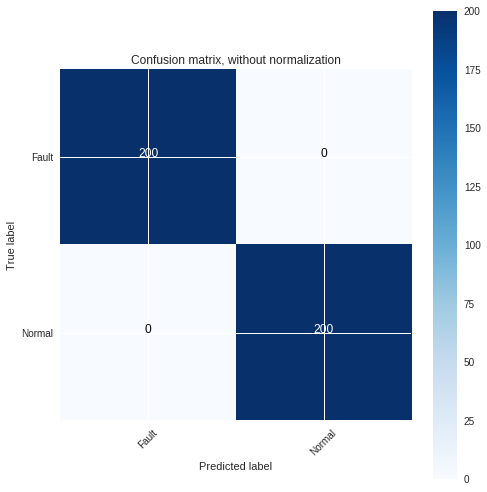

Normalized confusion matrix
[[1. 0.]
 [0. 1.]]


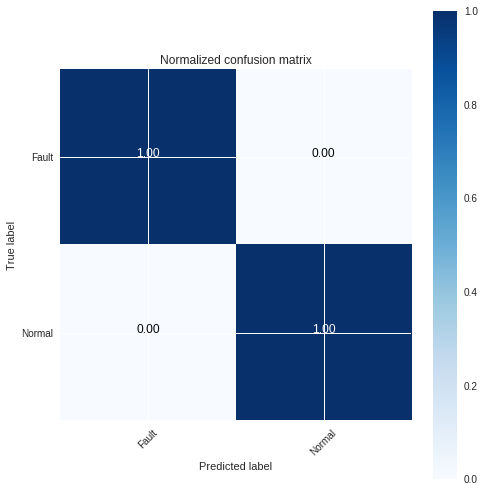

In [20]:
print('Printing Confusion Matrix')
Prediction_Test = my_model.predict(X_Test)

classNames = np.asarray(['Fault','Normal'])
cnf_matrix = confusion_matrix(np.argmax(Label_Test, axis=1), np.argmax(Prediction_Test, axis=1))
np.set_printoptions(precision=2)

fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classNames, title='Confusion matrix, without normalization')
plt.show()
fig.savefig('Prediction' + '.png')
# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classNames, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
fig.savefig('Prediction(Normalized)' + '.png')

In [0]:
Prediction_Rest = my_model.predict(X_Rest)

In [0]:
plt.plot(Prediction_Rest[:, 0])
np.savetxt("Rest.csv", Prediction_Rest, delimiter=",")